In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import os

import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(11, 9))
plt.rc('font', size=10)

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text


import acquire
import prepare

import warnings
warnings.filterwarnings("ignore")

## Acquire

In [2]:
from env import host, username, password

In [3]:
def get_db_url(db, username=username, host=host, password=password):
    
    return f'mysql+pymysql://{username}:{password}@{host}/{db}'

In [4]:
def new_telco_data():
    '''
    gets telco_churn information from CodeUp db and creates a dataframe
    '''

    # SQL query
    telco_query = '''SELECT * FROM customers
                JOIN contract_types USING (contract_type_id)
                JOIN internet_service_types USING (internet_service_type_id)
                JOIN payment_types USING (payment_type_id)'''
    
    # reads SQL query into a DataFrame            
    df = pd.read_sql(telco_query, get_db_url('telco_churn'))
    
    return df

def get_telco_data():
    '''
    checks for existing telco_churn csv file and loads if present,
    otherwise runs new_telco_data function to acquire data
    '''
    
    # checks for existing file and loads
    if os.path.isfile('telco_churn.csv'):
        
        df = pd.read_csv('telco_churn.csv', index_col=0)
        
    else:
        
        # pull in data and creates csv file if not already present
        df = new_telco_data()
        
        df.to_csv('telco_churn.csv')
    
    return df

In [5]:
telcodf = get_telco_data()
telcodf.head().T

,0,1,2,3,4
payment_type_id,2,4,3,4,3
internet_service_type_id,1,1,1,1,1
contract_type_id,3,3,3,3,3
customer_id,0016-QLJIS,0017-DINOC,0019-GFNTW,0056-EPFBG,0078-XZMHT
gender,Female,Male,Female,Male,Male
senior_citizen,0,0,0,0,0
partner,Yes,No,No,Yes,Yes
dependents,Yes,No,No,Yes,No
tenure,65,54,56,20,72
phone_service,Yes,No,No,No,Yes


In [6]:
# explore the data
telcodf.shape

(7043, 24)

In [7]:
telcodf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

In [8]:
telcodf.describe().T

,count,mean,std,min,25%,50%,75%,max
payment_type_id,7043.0,2.315633,1.148907,1.00,1.0,2.00,3.00,4.00
internet_service_type_id,7043.0,1.872923,0.737796,1.00,1.0,2.00,2.00,3.00
contract_type_id,7043.0,1.690473,0.833755,1.00,1.0,1.00,2.00,3.00
senior_citizen,7043.0,0.162147,0.368612,0.00,0.0,0.00,0.00,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00
monthly_charges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75


In [9]:
# check for number of unique values in each column
telcodf.nunique()

payment_type_id                4
internet_service_type_id       3
contract_type_id               3
customer_id                 7043
gender                         2
senior_citizen                 2
partner                        2
dependents                     2
tenure                        73
phone_service                  2
multiple_lines                 3
online_security                3
online_backup                  3
device_protection              3
tech_support                   3
streaming_tv                   3
streaming_movies               3
paperless_billing              2
monthly_charges             1585
total_charges               6531
churn                          2
contract_type                  3
internet_service_type          3
payment_type                   4
dtype: int64

## Data Prep

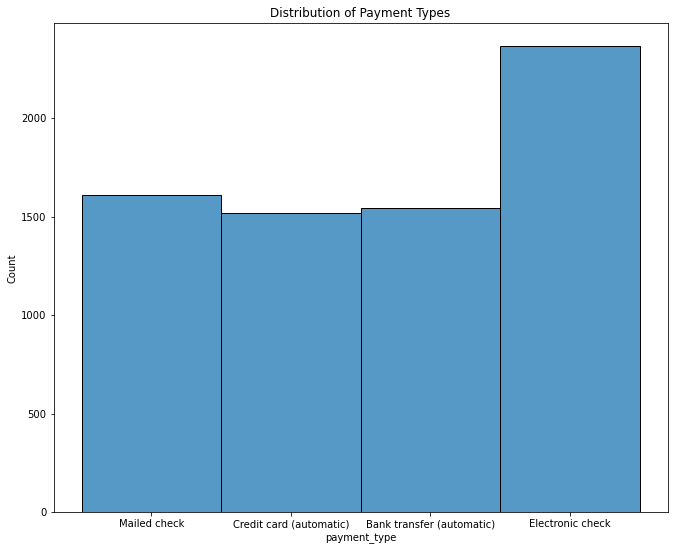

In [10]:
# quick viz of payment types
sns.histplot(data=telcodf.payment_type)
plt.title('Distribution of Payment Types')
plt.show()

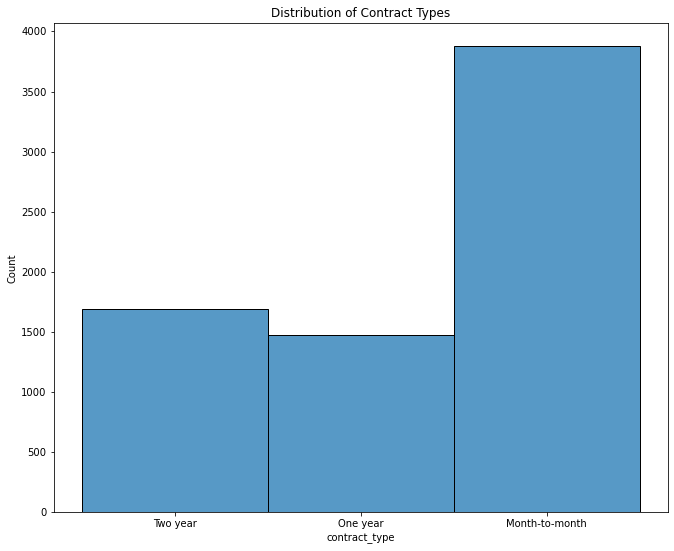

In [11]:
# quick viz of contract type
sns.histplot(data=telcodf.contract_type)
plt.title('Distribution of Contract Types')
plt.show()

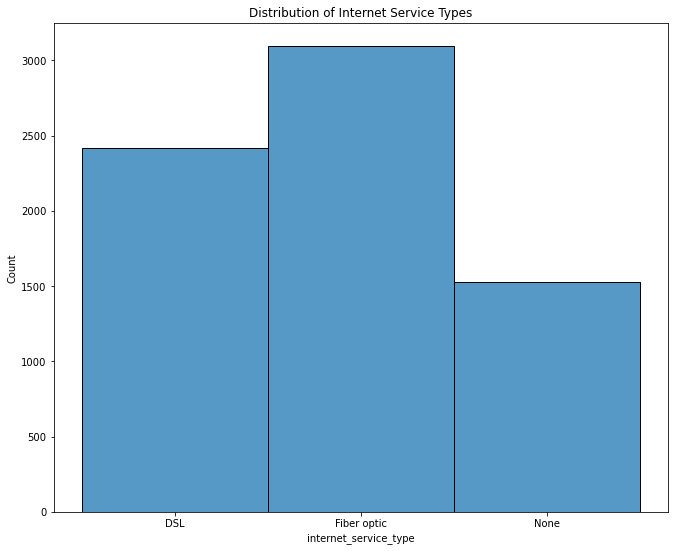

In [12]:
# quick viz of internet service type
# quick viz of contract type
sns.histplot(data=telcodf.internet_service_type)
plt.title('Distribution of Internet Service Types')
plt.show()

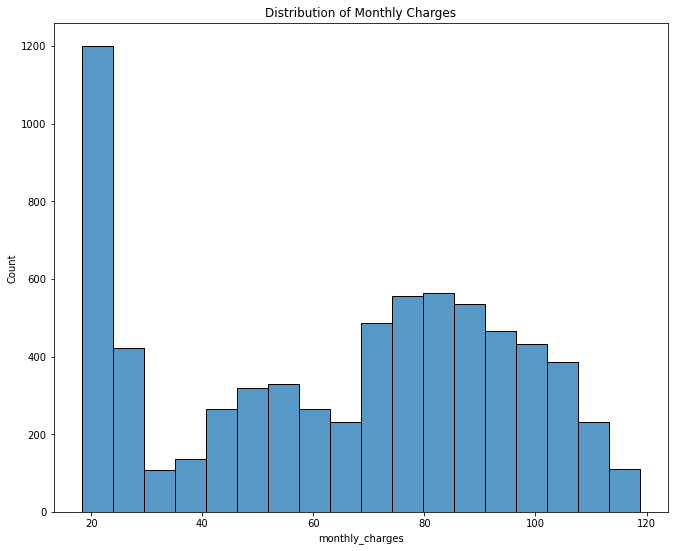

In [13]:
# quick viz of monthly charges
sns.histplot(data=telcodf.monthly_charges)
plt.title('Distribution of Monthly Charges')
plt.show()

In [14]:
telcodf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

In [15]:
# drop any duplicates
telcodf.drop_duplicates(inplace=True)
telcodf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

In [16]:
# set index to customer_id (no value in customer_id)
telcodf.set_index('customer_id', drop=True, inplace=True)
telcodf.head().T

customer_id,0016-QLJIS,0017-DINOC,0019-GFNTW,0056-EPFBG,0078-XZMHT
payment_type_id,2,4,3,4,3
internet_service_type_id,1,1,1,1,1
contract_type_id,3,3,3,3,3
gender,Female,Male,Female,Male,Male
senior_citizen,0,0,0,0,0
partner,Yes,No,No,Yes,Yes
dependents,Yes,No,No,Yes,No
tenure,65,54,56,20,72
phone_service,Yes,No,No,No,Yes
multiple_lines,Yes,No phone service,No phone service,No phone service,Yes


In [17]:
# fill any empty spaces with np.nan
telcodf.replace(' ', np.nan, inplace=True)
telcodf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0016-QLJIS to 9986-BONCE
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   gender                    7043 non-null   object 
 4   senior_citizen            7043 non-null   int64  
 5   partner                   7043 non-null   object 
 6   dependents                7043 non-null   object 
 7   tenure                    7043 non-null   int64  
 8   phone_service             7043 non-null   object 
 9   multiple_lines            7043 non-null   object 
 10  online_security           7043 non-null   object 
 11  online_backup             7043 non-null   object 
 12  device_protection         7043 non-null   object 
 13  tech_support              7043 non-null   object 
 14

In [18]:
# notice count difference in total_charges, 11 nulls, check relation to tenure
telcodf[telcodf.total_charges.isna()][['total_charges', 'tenure', 'churn']]

,total_charges,tenure,churn
customer_id,,,
1371-DWPAZ,NaN,0,No
2775-SEFEE,NaN,0,No
4075-WKNIU,NaN,0,No
4472-LVYGI,NaN,0,No
5709-LVOEQ,NaN,0,No
2520-SGTTA,NaN,0,No
3115-CZMZD,NaN,0,No
3213-VVOLG,NaN,0,No
4367-NUYAO,NaN,0,No


In [19]:
# all 11 nulls are new customers with no tenure and have not churned
# have over 7000 rows, no significant impact (11/7043=~0.16%), will drop nulls
telcodf.dropna(axis=0, inplace=True)
telcodf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0016-QLJIS to 9986-BONCE
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7032 non-null   int64  
 1   internet_service_type_id  7032 non-null   int64  
 2   contract_type_id          7032 non-null   int64  
 3   gender                    7032 non-null   object 
 4   senior_citizen            7032 non-null   int64  
 5   partner                   7032 non-null   object 
 6   dependents                7032 non-null   object 
 7   tenure                    7032 non-null   int64  
 8   phone_service             7032 non-null   object 
 9   multiple_lines            7032 non-null   object 
 10  online_security           7032 non-null   object 
 11  online_backup             7032 non-null   object 
 12  device_protection         7032 non-null   object 
 13  tech_support              7032 non-null   object 
 14

In [20]:
# since I'm working on total_charges...
# convert total_charges to a numeric data type
telcodf = telcodf.astype({'total_charges': 'float64'})
telcodf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0016-QLJIS to 9986-BONCE
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7032 non-null   int64  
 1   internet_service_type_id  7032 non-null   int64  
 2   contract_type_id          7032 non-null   int64  
 3   gender                    7032 non-null   object 
 4   senior_citizen            7032 non-null   int64  
 5   partner                   7032 non-null   object 
 6   dependents                7032 non-null   object 
 7   tenure                    7032 non-null   int64  
 8   phone_service             7032 non-null   object 
 9   multiple_lines            7032 non-null   object 
 10  online_security           7032 non-null   object 
 11  online_backup             7032 non-null   object 
 12  device_protection         7032 non-null   object 
 13  tech_support              7032 non-null   object 
 14

In [21]:
# already know will need to use tenure
# rename 'tenure' to 'tenure_months'
telcodf = telcodf.rename(columns={'tenure': 'tenure_months'})
telcodf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0016-QLJIS to 9986-BONCE
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7032 non-null   int64  
 1   internet_service_type_id  7032 non-null   int64  
 2   contract_type_id          7032 non-null   int64  
 3   gender                    7032 non-null   object 
 4   senior_citizen            7032 non-null   int64  
 5   partner                   7032 non-null   object 
 6   dependents                7032 non-null   object 
 7   tenure_months             7032 non-null   int64  
 8   phone_service             7032 non-null   object 
 9   multiple_lines            7032 non-null   object 
 10  online_security           7032 non-null   object 
 11  online_backup             7032 non-null   object 
 12  device_protection         7032 non-null   object 
 13  tech_support              7032 non-null   object 
 14

In [22]:
# add column for tenure in years
telcodf['tenure_years'] = telcodf.tenure_months / 12
telcodf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0016-QLJIS to 9986-BONCE
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7032 non-null   int64  
 1   internet_service_type_id  7032 non-null   int64  
 2   contract_type_id          7032 non-null   int64  
 3   gender                    7032 non-null   object 
 4   senior_citizen            7032 non-null   int64  
 5   partner                   7032 non-null   object 
 6   dependents                7032 non-null   object 
 7   tenure_months             7032 non-null   int64  
 8   phone_service             7032 non-null   object 
 9   multiple_lines            7032 non-null   object 
 10  online_security           7032 non-null   object 
 11  online_backup             7032 non-null   object 
 12  device_protection         7032 non-null   object 
 13  tech_support              7032 non-null   object 
 14

In [23]:
telcodf.head().T

customer_id,0016-QLJIS,0017-DINOC,0019-GFNTW,0056-EPFBG,0078-XZMHT
payment_type_id,2,4,3,4,3
internet_service_type_id,1,1,1,1,1
contract_type_id,3,3,3,3,3
gender,Female,Male,Female,Male,Male
senior_citizen,0,0,0,0,0
partner,Yes,No,No,Yes,Yes
dependents,Yes,No,No,Yes,No
tenure_months,65,54,56,20,72
phone_service,Yes,No,No,No,Yes
multiple_lines,Yes,No phone service,No phone service,No phone service,Yes


In [24]:
# first non-numeric column is 'gender'
# create dummy variable for gender - male=1, female=0
gender_dummy = pd.get_dummies(telcodf.gender, drop_first=True)
# add dummy to telcodf
telcodf = pd.concat([telcodf, gender_dummy], axis=1)
# now drop the 'gender' column
telcodf = telcodf.drop(columns='gender')

In [25]:
telcodf.head().T

customer_id,0016-QLJIS,0017-DINOC,0019-GFNTW,0056-EPFBG,0078-XZMHT
payment_type_id,2,4,3,4,3
internet_service_type_id,1,1,1,1,1
contract_type_id,3,3,3,3,3
senior_citizen,0,0,0,0,0
partner,Yes,No,No,Yes,Yes
dependents,Yes,No,No,Yes,No
tenure_months,65,54,56,20,72
phone_service,Yes,No,No,No,Yes
multiple_lines,Yes,No phone service,No phone service,No phone service,Yes
online_security,Yes,Yes,Yes,Yes,No


In [26]:
# want to convert column values into 0's, 1's, or 2's
# find values and counts for columns
for column in telcodf.columns:
    skip = ['tenure_months', 'monthly_charges', 'total_charges', 'tenure_years']
    if column not in skip:
        print(f'\n {column}')
        print(telcodf[column].value_counts())


 payment_type_id
1    2365
2    1604
3    1542
4    1521
Name: payment_type_id, dtype: int64

 internet_service_type_id
2    3096
1    2416
3    1520
Name: internet_service_type_id, dtype: int64

 contract_type_id
1    3875
3    1685
2    1472
Name: contract_type_id, dtype: int64

 senior_citizen
0    5890
1    1142
Name: senior_citizen, dtype: int64

 partner
No     3639
Yes    3393
Name: partner, dtype: int64

 dependents
No     4933
Yes    2099
Name: dependents, dtype: int64

 phone_service
Yes    6352
No      680
Name: phone_service, dtype: int64

 multiple_lines
No                  3385
Yes                 2967
No phone service     680
Name: multiple_lines, dtype: int64

 online_security
No                     3497
Yes                    2015
No internet service    1520
Name: online_security, dtype: int64

 online_backup
No                     3087
Yes                    2425
No internet service    1520
Name: online_backup, dtype: int64

 device_protection
No                     

In [27]:
# convert columns with 'Yes' and 'No' values to 1(yes) or 0(no)
telcodf.partner = telcodf.partner.replace({'No': 0, 'Yes': 1})
telcodf.dependents = telcodf.dependents.replace({'No': 0, 'Yes': 1})
telcodf.phone_service = telcodf.phone_service.replace({'No': 0, 'Yes': 1})
telcodf.paperless_billing = telcodf.paperless_billing.replace({'No': 0, 'Yes': 1})
telcodf.churn = telcodf.churn.replace({'No': 0, 'Yes': 1})

In [28]:
telcodf.head().T

customer_id,0016-QLJIS,0017-DINOC,0019-GFNTW,0056-EPFBG,0078-XZMHT
payment_type_id,2,4,3,4,3
internet_service_type_id,1,1,1,1,1
contract_type_id,3,3,3,3,3
senior_citizen,0,0,0,0,0
partner,1,0,0,1,1
dependents,1,0,0,1,0
tenure_months,65,54,56,20,72
phone_service,1,0,0,0,1
multiple_lines,Yes,No phone service,No phone service,No phone service,Yes
online_security,Yes,Yes,Yes,Yes,No


In [29]:
# noticed partner + dependents can be combined into single column
# combine 'partner' + 'dependents' into 'family', new values(0 = none, 1 = partner OR dependent, 2 = both)
telcodf['family'] = telcodf.partner + telcodf.dependents
# now can drop 'partner' and 'dependent' columns
telcodf = telcodf.drop(columns=['partner', 'dependents'])

In [30]:
telcodf.family.value_counts()

0    3280
1    2012
2    1740
Name: family, dtype: int64

In [31]:
telcodf.head().T

customer_id,0016-QLJIS,0017-DINOC,0019-GFNTW,0056-EPFBG,0078-XZMHT
payment_type_id,2,4,3,4,3
internet_service_type_id,1,1,1,1,1
contract_type_id,3,3,3,3,3
senior_citizen,0,0,0,0,0
tenure_months,65,54,56,20,72
phone_service,1,0,0,0,1
multiple_lines,Yes,No phone service,No phone service,No phone service,Yes
online_security,Yes,Yes,Yes,Yes,No
online_backup,Yes,No,Yes,No,Yes
device_protection,Yes,No,Yes,Yes,Yes


In [32]:
# noticed 'phone_service' and 'multiple_lines' contain the same information, can create single column
# change string values in multiple_lines, new values(0 = no phone service, 1 = single line, 2 = multiple lines)
telcodf.multiple_lines = telcodf.multiple_lines.replace({'No phone service': 0, 'No': 1, 'Yes': 2})
# can now drop original 'phone_service' column
telcodf = telcodf.drop(columns='phone_service')
# rename 'multiple_lines' to 'phone_service'
telcodf = telcodf.rename(columns={'multiple_lines': 'phone_service'})

In [33]:
telcodf.phone_service.value_counts()

1    3385
2    2967
0     680
Name: phone_service, dtype: int64

In [34]:
telcodf.head().T

customer_id,0016-QLJIS,0017-DINOC,0019-GFNTW,0056-EPFBG,0078-XZMHT
payment_type_id,2,4,3,4,3
internet_service_type_id,1,1,1,1,1
contract_type_id,3,3,3,3,3
senior_citizen,0,0,0,0,0
tenure_months,65,54,56,20,72
phone_service,2,0,0,0,2
online_security,Yes,Yes,Yes,Yes,No
online_backup,Yes,No,Yes,No,Yes
device_protection,Yes,No,Yes,Yes,Yes
tech_support,Yes,Yes,Yes,Yes,Yes


In [35]:
# want to combine similiar services into single columns
# start with 'online_security' and 'online_backup'
# encode values to 1(Yes) or 0(No and No internet service(same thing))
telcodf.online_security = telcodf.online_security.replace({'No internet service': 0, 'No': 0, 'Yes': 1})
telcodf.online_backup = telcodf.online_backup.replace({'No internet service': 0, 'No': 0, 'Yes': 1})
# combine 'online_security' and 'online_backup' into 'online_services', new values(0 = no internet service, 1 = security OR backup, 2 = both)
telcodf['online_services'] = telcodf.online_security + telcodf.online_backup
# now can drop 'online_security' and 'online_backup' columns
telcodf = telcodf.drop(columns=['online_security', 'online_backup'])

In [36]:
telcodf.online_services.value_counts()

0    3715
1    2194
2    1123
Name: online_services, dtype: int64

In [37]:
telcodf.head().T

customer_id,0016-QLJIS,0017-DINOC,0019-GFNTW,0056-EPFBG,0078-XZMHT
payment_type_id,2,4,3,4,3
internet_service_type_id,1,1,1,1,1
contract_type_id,3,3,3,3,3
senior_citizen,0,0,0,0,0
tenure_months,65,54,56,20,72
phone_service,2,0,0,0,2
device_protection,Yes,No,Yes,Yes,Yes
tech_support,Yes,Yes,Yes,Yes,Yes
streaming_tv,Yes,Yes,No,No,Yes
streaming_movies,Yes,No,No,No,Yes


In [38]:
# next - 'device_protection' and 'tech_support'
# encode values to 1(Yes) or 0(No and No internet service(same thing))
telcodf.device_protection = telcodf.device_protection.replace({'No internet service': 0, 'No': 0, 'Yes': 1})
telcodf.tech_support = telcodf.tech_support.replace({'No internet service': 0, 'No': 0, 'Yes': 1})
# combine 'device_protection' and 'tech_support' into 'support_services', new values(0 = no internet service, 1 = device_protection OR tech_support, 2 = both)
telcodf['support_services'] = telcodf.device_protection + telcodf.tech_support
# now can drop 'device_protection' and 'tech_support' columns
telcodf = telcodf.drop(columns=['device_protection', 'tech_support'])

In [39]:
telcodf.online_services.value_counts()

0    3715
1    2194
2    1123
Name: online_services, dtype: int64

In [40]:
telcodf.head().T

customer_id,0016-QLJIS,0017-DINOC,0019-GFNTW,0056-EPFBG,0078-XZMHT
payment_type_id,2,4,3,4,3
internet_service_type_id,1,1,1,1,1
contract_type_id,3,3,3,3,3
senior_citizen,0,0,0,0,0
tenure_months,65,54,56,20,72
phone_service,2,0,0,0,2
streaming_tv,Yes,Yes,No,No,Yes
streaming_movies,Yes,No,No,No,Yes
paperless_billing,1,0,0,1,1
monthly_charges,90.45,45.2,45.05,39.4,85.15


In [41]:
# next - 'streaming_tv' and 'streaming_movies'
# encode values to 1(Yes) or 0(No and No internet service(same thing))
telcodf.streaming_tv = telcodf.streaming_tv.replace({'No internet service': 0, 'No': 0, 'Yes': 1})
telcodf.streaming_movies = telcodf.streaming_movies.replace({'No internet service': 0, 'No': 0, 'Yes': 1})
# combine 'streaming_tv' and 'streaming_movies' into 'streaming_services', new values(0 = no internet service, 1 = streaming_tv OR streaming_movies, 2 = both)
telcodf['streaming_services'] = telcodf.streaming_tv + telcodf.streaming_movies
# now can drop 'streaming_tv' and 'streaming_movies' columns
telcodf = telcodf.drop(columns=['streaming_tv', 'streaming_movies'])

In [42]:
telcodf.streaming_services.value_counts()

0    3537
2    1939
1    1556
Name: streaming_services, dtype: int64

In [43]:
telcodf.head().T

customer_id,0016-QLJIS,0017-DINOC,0019-GFNTW,0056-EPFBG,0078-XZMHT
payment_type_id,2,4,3,4,3
internet_service_type_id,1,1,1,1,1
contract_type_id,3,3,3,3,3
senior_citizen,0,0,0,0,0
tenure_months,65,54,56,20,72
phone_service,2,0,0,0,2
paperless_billing,1,0,0,1,1
monthly_charges,90.45,45.2,45.05,39.4,85.15
total_charges,5957.9,2460.55,2560.1,825.4,6316.2
churn,0,0,0,0,0


In [44]:
telcodf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0016-QLJIS to 9986-BONCE
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7032 non-null   int64  
 1   internet_service_type_id  7032 non-null   int64  
 2   contract_type_id          7032 non-null   int64  
 3   senior_citizen            7032 non-null   int64  
 4   tenure_months             7032 non-null   int64  
 5   phone_service             7032 non-null   int64  
 6   paperless_billing         7032 non-null   int64  
 7   monthly_charges           7032 non-null   float64
 8   total_charges             7032 non-null   float64
 9   churn                     7032 non-null   int64  
 10  contract_type             7032 non-null   object 
 11  internet_service_type     7032 non-null   object 
 12  payment_type              7032 non-null   object 
 13  tenure_years              7032 non-null   float64
 14

In [45]:
# check the column values again
# find values and counts for columns
for column in telcodf.columns:
    skip = ['tenure_months', 'monthly_charges', 'total_charges', 'tenure_years']
    if column not in skip:
        print(f'\n {column}')
        print(telcodf[column].value_counts())


 payment_type_id
1    2365
2    1604
3    1542
4    1521
Name: payment_type_id, dtype: int64

 internet_service_type_id
2    3096
1    2416
3    1520
Name: internet_service_type_id, dtype: int64

 contract_type_id
1    3875
3    1685
2    1472
Name: contract_type_id, dtype: int64

 senior_citizen
0    5890
1    1142
Name: senior_citizen, dtype: int64

 phone_service
1    3385
2    2967
0     680
Name: phone_service, dtype: int64

 paperless_billing
1    4168
0    2864
Name: paperless_billing, dtype: int64

 churn
0    5163
1    1869
Name: churn, dtype: int64

 contract_type
Month-to-month    3875
Two year          1685
One year          1472
Name: contract_type, dtype: int64

 internet_service_type
Fiber optic    3096
DSL            2416
None           1520
Name: internet_service_type, dtype: int64

 payment_type
Electronic check             2365
Mailed check                 1604
Bank transfer (automatic)    1542
Credit card (automatic)      1521
Name: payment_type, dtype: int64

 Mal

In [46]:
telcodf.payment_type_id.value_counts()

1    2365
2    1604
3    1542
4    1521
Name: payment_type_id, dtype: int64

In [47]:
telcodf.payment_type.value_counts()

Electronic check             2365
Mailed check                 1604
Bank transfer (automatic)    1542
Credit card (automatic)      1521
Name: payment_type, dtype: int64

In [48]:
# 'payment_type' and 'payment_type_id' have the same information
# convert 'payment_type_id', new values(0 = manual_pay, 1 = auto_pay)
telcodf.payment_type_id = telcodf.payment_type_id.replace({1: 0, 2: 0, 3: 1, 4: 1})
# rename 'payment_type_id' to 'auto_pay'
telcodf = telcodf.rename(columns={'payment_type_id': 'auto_pay'})

In [49]:
# now can drop column 'payment_type'
telcodf = telcodf.drop(columns='payment_type')

In [50]:
telcodf.auto_pay.value_counts()

0    3969
1    3063
Name: auto_pay, dtype: int64

In [51]:
telcodf.head().T

customer_id,0016-QLJIS,0017-DINOC,0019-GFNTW,0056-EPFBG,0078-XZMHT
auto_pay,0,1,1,1,1
internet_service_type_id,1,1,1,1,1
contract_type_id,3,3,3,3,3
senior_citizen,0,0,0,0,0
tenure_months,65,54,56,20,72
phone_service,2,0,0,0,2
paperless_billing,1,0,0,1,1
monthly_charges,90.45,45.2,45.05,39.4,85.15
total_charges,5957.9,2460.55,2560.1,825.4,6316.2
churn,0,0,0,0,0


In [52]:
telcodf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0016-QLJIS to 9986-BONCE
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   auto_pay                  7032 non-null   int64  
 1   internet_service_type_id  7032 non-null   int64  
 2   contract_type_id          7032 non-null   int64  
 3   senior_citizen            7032 non-null   int64  
 4   tenure_months             7032 non-null   int64  
 5   phone_service             7032 non-null   int64  
 6   paperless_billing         7032 non-null   int64  
 7   monthly_charges           7032 non-null   float64
 8   total_charges             7032 non-null   float64
 9   churn                     7032 non-null   int64  
 10  contract_type             7032 non-null   object 
 11  internet_service_type     7032 non-null   object 
 12  tenure_years              7032 non-null   float64
 13  Male                      7032 non-null   uint8  
 14

In [53]:
# 'contract_type' and 'contract_type_id' have the same information
# convert 'contract_type', new values(0 = 'Month-to-month', 1 = 'One year', 2 = 'Two year')
telcodf.contract_type = telcodf.contract_type.replace({'Month-to-month': 0, 'One year': 1, 'Two year': 2})

In [54]:
# now can drop column 'contract_type_id'
telcodf = telcodf.drop(columns='contract_type_id')

In [55]:
telcodf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0016-QLJIS to 9986-BONCE
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   auto_pay                  7032 non-null   int64  
 1   internet_service_type_id  7032 non-null   int64  
 2   senior_citizen            7032 non-null   int64  
 3   tenure_months             7032 non-null   int64  
 4   phone_service             7032 non-null   int64  
 5   paperless_billing         7032 non-null   int64  
 6   monthly_charges           7032 non-null   float64
 7   total_charges             7032 non-null   float64
 8   churn                     7032 non-null   int64  
 9   contract_type             7032 non-null   int64  
 10  internet_service_type     7032 non-null   object 
 11  tenure_years              7032 non-null   float64
 12  Male                      7032 non-null   uint8  
 13  family                    7032 non-null   int64  
 14

In [56]:
# 'internet_service_type' and 'internet_service_type_id' have the same information
# convert 'internet_service_type', new values(0 = 'None', 1 = 'DSL', 2 = 'Fiber optic')
telcodf.internet_service_type = telcodf.internet_service_type.replace({'None': 0, 'DSL': 1, 'Fiber optic': 2})

In [57]:
# now can drop column 'internet_service_type_id'
telcodf = telcodf.drop(columns='internet_service_type_id')

In [58]:
telcodf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0016-QLJIS to 9986-BONCE
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   auto_pay               7032 non-null   int64  
 1   senior_citizen         7032 non-null   int64  
 2   tenure_months          7032 non-null   int64  
 3   phone_service          7032 non-null   int64  
 4   paperless_billing      7032 non-null   int64  
 5   monthly_charges        7032 non-null   float64
 6   total_charges          7032 non-null   float64
 7   churn                  7032 non-null   int64  
 8   contract_type          7032 non-null   int64  
 9   internet_service_type  7032 non-null   int64  
 10  tenure_years           7032 non-null   float64
 11  Male                   7032 non-null   uint8  
 12  family                 7032 non-null   int64  
 13  online_services        7032 non-null   int64  
 14  support_services       7032 non-null   int64  

In [59]:
telcodf.head().T

customer_id,0016-QLJIS,0017-DINOC,0019-GFNTW,0056-EPFBG,0078-XZMHT
auto_pay,0.000000,1.00,1.000000,1.000000,1.00
senior_citizen,0.000000,0.00,0.000000,0.000000,0.00
tenure_months,65.000000,54.00,56.000000,20.000000,72.00
phone_service,2.000000,0.00,0.000000,0.000000,2.00
paperless_billing,1.000000,0.00,0.000000,1.000000,1.00
monthly_charges,90.450000,45.20,45.050000,39.400000,85.15
total_charges,5957.900000,2460.55,2560.100000,825.400000,6316.20
churn,0.000000,0.00,0.000000,0.000000,0.00
contract_type,2.000000,2.00,2.000000,2.000000,2.00
internet_service_type,1.000000,1.00,1.000000,1.000000,1.00


In [60]:
def telco_split(df):
    '''
    This function takes in the telco data acquired by get_telco_data,
    performs a split and stratifies on churn column.
    Returns train, validate, and test dfs.
    '''
    train_validate, test = train_test_split(df, test_size=0.2, 
                                        random_state=1234, 
                                        stratify=df.churn)
    train, validate = train_test_split(train_validate, train_size=0.7, 
                                   random_state=1234, 
                                   stratify=train_validate.churn)
    return train, validate, test


In [61]:
train, validate, test = telco_split(telcodf)

print(f'train -> {train.shape}')
print(f'validate -> {validate.shape}')
print(f'test -> {test.shape}')

train -> (3937, 16)
validate -> (1688, 16)
test -> (1407, 16)


In [62]:
for column in train.columns:
    skip = ['tenure_months', 'monthly_charges', 'total_charges', 'tenure_years']
    if column not in skip:
        print(f'\n {column}')
        print(train[column].value_counts())


 auto_pay
0    2249
1    1688
Name: auto_pay, dtype: int64

 senior_citizen
0    3293
1     644
Name: senior_citizen, dtype: int64

 phone_service
1    1877
2    1693
0     367
Name: phone_service, dtype: int64

 paperless_billing
1    2384
0    1553
Name: paperless_billing, dtype: int64

 churn
0    2891
1    1046
Name: churn, dtype: int64

 contract_type
0    2157
2     947
1     833
Name: contract_type, dtype: int64

 internet_service_type
2    1769
1    1332
0     836
Name: internet_service_type, dtype: int64

 Male
1    1984
0    1953
Name: Male, dtype: int64

 family
0    1801
1    1116
2    1020
Name: family, dtype: int64

 online_services
0    2033
1    1239
2     665
Name: online_services, dtype: int64

 support_services
0    2135
1    1117
2     685
Name: support_services, dtype: int64

 streaming_services
0    1987
2    1092
1     858
Name: streaming_services, dtype: int64


### Explore

In [63]:
churn_rate = len(train[train.churn == 1])/len(train.churn)
print(f'Overall churn rate is {churn_rate:.2%}')

Overall churn rate is 26.57%


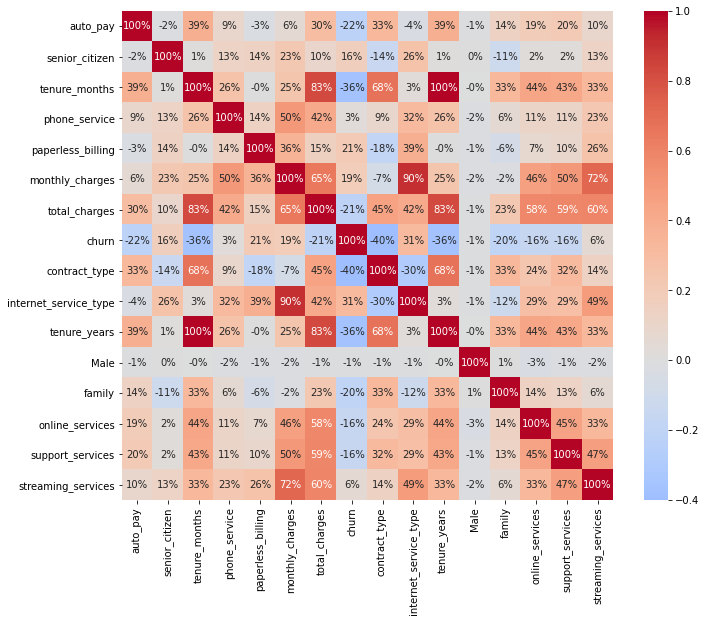

In [64]:
sns.heatmap(train.corr(), cmap='coolwarm', center=0, annot=True, fmt='.0%')

plt.title('')
plt.show()

### Takeaways

- highest associations with churn:
-- contract type (negative)
-- internet service type (positive)
-- tenure (negative)
-- paperless billing (positive)
-- auto-pay (negative)

## Internet Service Type

- Does the type of internet service affect churn?
- The heatmap shows this category has the highest positive correlation.

Form hypothesis #1:

- $H_0$ The type of internet service has no affect on churn (independent)
- $H_a$ The type of internet service does have an affect on churn (dependent)

In [65]:
# examine the 3 types of internet service and the relation to churn
# make a crosstab
# internet_service_types values = (0 = 'None', 1 = 'DSL', 2 = 'Fiber optic')
# churn values = (No = 0, Yes = 1)
observed1 = pd.crosstab(train.internet_service_type, train.churn)

# run the chi^2 test
chi2, p, degf, expected = stats.chi2_contingency(observed1)

print('Observed\n')
print(observed1.values)
print('---\nExpected\n')
print(expected.astype(int))
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

# set alpha
alpha = 0.05

null_hypothesis = "the type of internet service has no affect on churn."

if p < alpha:
    print(f'\nWe can reject the null hypothesis that', null_hypothesis)
else:
    print(f'\nWe fail to reject the null hypothesis.')

Observed

[[ 768   68]
 [1095  237]
 [1028  741]]
---
Expected

[[ 613  222]
 [ 978  353]
 [1299  469]]
---

chi^2 = 411.0003
p     = 0.0000

We can reject the null hypothesis that the type of internet service has no affect on churn.


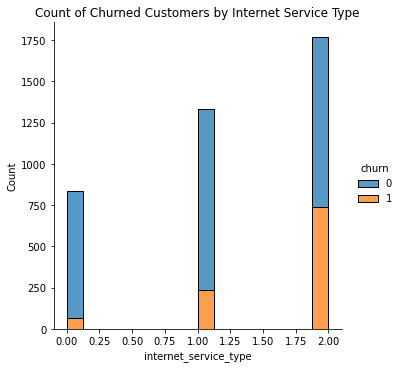

In [66]:
# visual of internet service type customers that have and have not churned
sns.displot(data=train, x=train.internet_service_type, hue='churn', multiple='stack')
plt.title('Count of Churned Customers by Internet Service Type')
plt.show()

In [67]:
# observed1 df for reference
observed1

churn,0,1
internet_service_type,,
0,768,68
1,1095,237
2,1028,741


### Takeaways

- there is evidence to support the idea that internet service type has an affect on churn
- churn rate for internet service types:
-- no internet service = 68 / (68 + 768) = 0.0813
-- DSL = 237 / (237 + 1095) = 0.1779
-- Fiber optic = 741 / (741 + 1028) = 0.4189
- Fiber optic service has the highest rate of churn within the internet service type category
- Fiber optic churn rate is higher than the overall churn rate

## Automatic Payment

- Does having a form of auto-pay affect churn?
- The heatmap shows this category has the third highest negative correlation.

Form hypothesis #2:

- $H_0$ Having a form of auto-pay has no affect on churn (independent)
- $H_a$ Having a form of auto-pay does have an affect on churn (dependent)

In [68]:
# examine auto-pay and the relation to churn
# make a crosstab
# auto_pay values = (0 = manual_pay, 1 = auto_pay)
# churn values = (No = 0, Yes = 1)
observed2 = pd.crosstab(train.auto_pay, train.churn)

# run the chi^2 test
chi2, p, degf, expected = stats.chi2_contingency(observed2)

print('Observed\n')
print(observed2.values)
print('---\nExpected\n')
print(expected.astype(int))
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

# set alpha
alpha = 0.05

null_hypothesis = "having a form of auto-pay has no affect on churn."

if p < alpha:
    print(f'\nWe can reject the null hypothesis that', null_hypothesis)
else:
    print(f'\nWe fail to reject the null hypothesis.')

Observed

[[1460  789]
 [1431  257]]
---
Expected

[[1651  597]
 [1239  448]]
---

chi^2 = 193.8697
p     = 0.0000

We can reject the null hypothesis that having a form of auto-pay has no affect on churn.


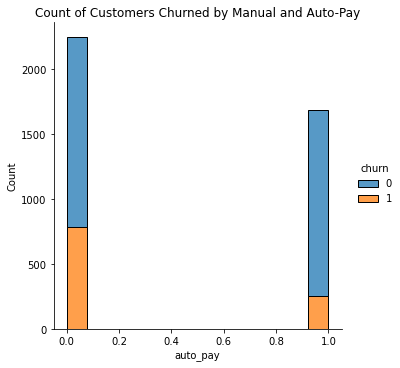

In [69]:
# visual of manual and auto-pay customers that have and have not churned
sns.displot(data=train, x=train.auto_pay, hue='churn', multiple='stack')
plt.title('Count of Customers Churned by Manual and Auto-Pay')
plt.show()

In [70]:
# observed2 df for reference
observed2

churn,0,1
auto_pay,,
0,1460,789
1,1431,257


### Takeaways

- there is evidence to support the idea that auto-payment has an affect on churn
- churn rates for manual or auto-pay:
-- manual = 789 / (789 + 1460) = 0.3508
-- auto-pay = 257 / (257 + 1431) = 0.1523
- Manual pay has the highest rate of churn within the auto-pay category
- Manual pay churn rate is higher than the overall churn rate

## Tenure

- The heatmap shows that tenure has the second highest negative correlation to churn.
- When do most customers churn?

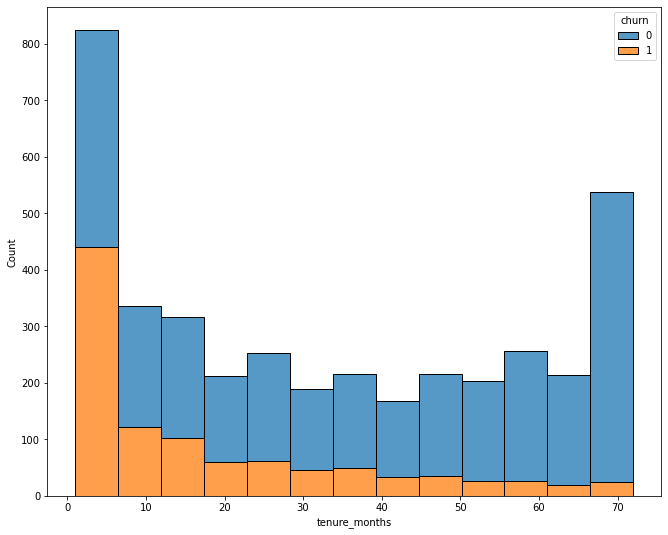

In [71]:
# quick viz of churn by tenure in months
sns.histplot(data=train, x='tenure_months', hue='churn', multiple='stack')
plt.show()

### Takeaway

- it appears that the churn rate is significantly higher during the first 6 months and declines after that

Form hypothesis #3:

- $H_0$ Tenure less than 6 months has the same churn rate as tenure longer than 6 months
- $H_a$ Tenure less than 6 months has a higher or lower churn rate than tenure longer than 6 months

In [72]:
# make a subset for tenure equal to or less than 6 months
x1 = train[train.tenure_months <= 6].churn

# make a subset for tenure greater than 6 months
x2 = train[train.tenure_months > 6].churn

# check the variances
print('tenure <= 6 months:', x1.var(), 'tenure > 6 months:', x2.var())

# run a 2 sample, 2 tail t-test
stat, p = stats.ttest_ind(x1, x2)

print(f'\nstatistic = {stat:.4f}')
print(f'p_value = {p:.4f}')

# set alpha
alpha = 0.05

null_hypothesis = "tenure less than 6 months has the same churn rate as tenure longer than 6 months."

if p < alpha:
    print(f'\nWe can reject the null hypothesis that', null_hypothesis)
else:
    print(f'\nWe fail to reject the null hypothesis.')

tenure <= 6 months: 0.24914768370512874 tenure > 6 months: 0.15682245529775177

statistic = 20.6372
p_value = 0.0000

We can reject the null hypothesis that tenure less than 6 months has the same churn rate as tenure longer than 6 months.


### Takeaway

- there is evidence to support the idea that tenure less than 6 months has a higher churn rate than tenure longer than 6 months

## Model & Evaluate

### Baseline

In [73]:
# split train, validate and test into X(variables) and y(target)
X_train, y_train = train.drop(columns='churn'), train.churn
X_validate, y_validate = validate.drop(columns='churn'), validate.churn
X_test, y_test = test.drop(columns='churn'), test.churn

In [74]:
# check values counts to establish baseline
train.churn.value_counts(), train.churn.value_counts(normalize=True)

(0    2891
 1    1046
 Name: churn, dtype: int64,
 0    0.734315
 1    0.265685
 Name: churn, dtype: float64)

In [75]:
# baseline prediction = 0 (not churned)

# create the baseline with constant equal to highest value from y_train
baseline = DummyClassifier(strategy='constant', constant=0)
# fit the baseline to the train subset
baseline.fit(X_train, y_train)
# accuracy of the baseline on the train subset
print(f'Baseline accuracy on the train subset: %.4f' % baseline.score(X_train, y_train))

Baseline accuracy on the train subset: 0.7343


### Model 1 - Logistic Regression

In [87]:
# using the top 6 features with highest correlation (excluding monthly_charges and total_charges)
# features had more than 20% correlation 
features1 = ['auto_pay', 'tenure_months', 'paperless_billing', 'contract_type', 'internet_service_type', 'family']

# create the model
logit1 = LogisticRegression(random_state=1234)

# fit the model
logit1.fit(X_train[features1], y_train)

# use the model to make predictions
y_pred_logit1 = logit1.predict(X_train[features1])

# use the model to predict probabilities
y_pred_proba_logit1 = logit1.predict_proba(X_train[features1])

# accuracy of the model
print('\nAccuracy of logit1 classifier on training set:',logit1.score(X_train[features1], y_train))

print('\nThe confusion matrix:\n',confusion_matrix(y_train, y_pred_logit1))
print('\nClassification report:\n',classification_report(y_train, y_pred_logit1))


Accuracy of logit1 classifier on training set: 0.8031496062992126

The confusion matrix:
 [[2593  298]
 [ 477  569]]

Classification report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87      2891
           1       0.66      0.54      0.59      1046

    accuracy                           0.80      3937
   macro avg       0.75      0.72      0.73      3937
weighted avg       0.79      0.80      0.80      3937



In [98]:
print(f'Model score for logit1 on train subset is: {logit1.score(X_train[features1], y_train):.4}')
print(f'Model score for logit11 on validate subset is: {logit1.score(X_validate[features1], y_validate):.4}')

Model score for logit1 on train subset is: 0.8031
Model score for logit11 on validate subset is: 0.7986


In [91]:
# using only the top 3 features with highest correlation (excluding monthly_charges and total_charges)
features2 = ['contract_type', 'internet_service_type', 'auto_pay']

# create the model
logit2 = LogisticRegression(random_state=1234)

# fit the model
logit2.fit(X_train[features2], y_train)

# use the model to make predictions
y_pred_logit2 = logit2.predict(X_train[features2])

# use the model to predict probabilities
y_pred_proba_logit2 = logit2.predict_proba(X_train[features2])

# accuracy of the model
print('\nAccuracy of logit2 classifier on training set:',logit2.score(X_train[features2], y_train))

print('\nThe confusion matrix:\n',confusion_matrix(y_train, y_pred_logit2))
print('\nClassification report:\n',classification_report(y_train, y_pred_logit2))


Accuracy of logit2 classifier on training set: 0.776987553975108

The confusion matrix:
 [[2540  351]
 [ 527  519]]

Classification report:
               precision    recall  f1-score   support

           0       0.83      0.88      0.85      2891
           1       0.60      0.50      0.54      1046

    accuracy                           0.78      3937
   macro avg       0.71      0.69      0.70      3937
weighted avg       0.77      0.78      0.77      3937



In [99]:
print(f'Model score for logit2 on train subset is: {logit2.score(X_train[features2], y_train):.4}')
print(f'Model score for logit2 on validate subset is: {logit2.score(X_validate[features2], y_validate):.4}')

Model score for logit2 on train subset is: 0.777
Model score for logit2 on validate subset is: 0.7648


#### Takeaways

- logit1 - using 6 features - accuracy: 0.8031, f1 score: 0.59 (best)
- logit2 - using 4 features - accuracy: 0.7769, f1 score: 0.54
-- no additional hyperparamaeters were set
-- adding and/or adjusting hyperparameters could lead to better results

### Model 2 - Decision Tree

In [92]:
# using the top 6 features with highest correlation (excluding monthly_charges and total_charges)
# features had more than 20% correlation 
features1 = ['auto_pay', 'tenure_months', 'paperless_billing', 'contract_type', 'internet_service_type', 'family']

# create the model
tree1 = DecisionTreeClassifier(max_depth=3, random_state=1234)

# fit the object
tree1.fit(X_train[features1], y_train)

# use the model to make predictions
y_pred_tree1 = tree1.predict(X_train[features1])

# use the model to predict probabilities
y_pred_proba_tree1 = tree1.predict_proba(X_train[features1])

# accuracy of the model
print('\nAccuracy of tree1 classifier on training set:',tree1.score(X_train[features1], y_train))

print('\nThe confusion matrix:\n',confusion_matrix(y_train, y_pred_tree1))
print('\nClassification report:\n',classification_report(y_train, y_pred_tree1))


Accuracy of tree1 classifier on training set: 0.7907035814071628

The confusion matrix:
 [[2705  186]
 [ 638  408]]

Classification report:
               precision    recall  f1-score   support

           0       0.81      0.94      0.87      2891
           1       0.69      0.39      0.50      1046

    accuracy                           0.79      3937
   macro avg       0.75      0.66      0.68      3937
weighted avg       0.78      0.79      0.77      3937



In [94]:
print(f'Model score for tree1 on train subset is: {tree1.score(X_train[features1], y_train):.4}')
print(f'Model score for tree1 on validate subset is: {tree1.score(X_validate[features1], y_validate):.4}')

Model score for tree1 on train subset is: 0.7907
Model score for tree1 on validate subset is: 0.7891


In [93]:
# using only the top 3 features with highest correlation (excluding monthly_charges and total_charges)
features2 = ['contract_type', 'internet_service_type', 'auto_pay']

# create the model
tree2 = DecisionTreeClassifier(max_depth=3, random_state=1234)

# fit the object
tree2.fit(X_train[features2], y_train)

# use the model to make predictions
y_pred_tree2 = tree2.predict(X_train[features2])

# use the model to predict probabilities
y_pred_proba_tree2 = tree2.predict_proba(X_train[features2])

# accuracy of the model
print('\nAccuracy of tree2 classifier on training set:',tree2.score(X_train[features2], y_train))

print('\nThe confusion matrix:\n',confusion_matrix(y_train, y_pred_tree2))
print('\nClassification report:\n',classification_report(y_train, y_pred_tree2))


Accuracy of tree2 classifier on training set: 0.776987553975108

The confusion matrix:
 [[2540  351]
 [ 527  519]]

Classification report:
               precision    recall  f1-score   support

           0       0.83      0.88      0.85      2891
           1       0.60      0.50      0.54      1046

    accuracy                           0.78      3937
   macro avg       0.71      0.69      0.70      3937
weighted avg       0.77      0.78      0.77      3937



In [95]:
print(f'Model score for tree1 on train subset is: {tree2.score(X_train[features2], y_train):.4}')
print(f'Model score for tree1 on validate subset is: {tree2.score(X_validate[features2], y_validate):.4}')

Model score for tree1 on train subset is: 0.777
Model score for tree1 on validate subset is: 0.7648


#### Takeaways

- tree1 - using 6 features - accuracy: 0.7907, f1 score: 0.50 (best)
- tree2 - using 4 features - accuracy: 0.7769, f1 score: 0.54
-- hyperparameters - max_depth = 3
-- adding and/or adjusting hyperparameters could lead to better results

### Model 3 - Random Forest

In [84]:
# using the top 6 features with highest correlation (excluding monthly_charges and total_charges)
# features had more than 20% correlation 
features1 = ['auto_pay', 'tenure_months', 'paperless_billing', 'contract_type', 'internet_service_type', 'family']

# create the model
rf1 = RandomForestClassifier(max_depth=10, min_samples_leaf=1, random_state=1234)

# fit the object
rf1.fit(X_train[features1], y_train)

# use the model to make predictions
y_pred_rf1 = rf1.predict(X_train[features1])

# use the model to predict probabilities
y_pred_proba_rf1 = rf1.predict_proba(X_train[features1])

# accuracy of the model
print('\nAccuracy of rf1 classifier on training set:',rf1.score(X_train[features1], y_train))

print('\nThe confusion matrix:\n',confusion_matrix(y_train, y_pred_rf1))
print('\nClassification report:\n',classification_report(y_train, y_pred_rf1))


Accuracy of rf1 classifier on training set: 0.8516637033274067

The confusion matrix:
 [[2621  270]
 [ 314  732]]

Classification report:
               precision    recall  f1-score   support

           0       0.89      0.91      0.90      2891
           1       0.73      0.70      0.71      1046

    accuracy                           0.85      3937
   macro avg       0.81      0.80      0.81      3937
weighted avg       0.85      0.85      0.85      3937



In [96]:
print(f'Model score for rf1 on train subset is: {rf1.score(X_train[features1], y_train):.4}')
print(f'Model score for rf1 on validate subset is: {rf1.score(X_validate[features1], y_validate):.4}')

Model score for rf1 on train subset is: 0.8517
Model score for tree1 on validate subset is: 0.7678


In [85]:
# using only the top 3 features with highest correlation (excluding monthly_charges and total_charges)
features2 = ['contract_type', 'internet_service_type', 'auto_pay']

# create the model
rf2 = RandomForestClassifier(max_depth=10, min_samples_leaf=1, random_state=1234)

# fit the object
rf2.fit(X_train[features2], y_train)

# use the model to make predictions
y_pred_rf2 = rf2.predict(X_train[features2])

# use the model to predict probabilities
y_pred_proba_rf2 = rf2.predict_proba(X_train[features2])

# accuracy of the model
print('\nAccuracy of rf2 classifier on training set:',rf2.score(X_train[features2], y_train))

print('\nThe confusion matrix:\n',confusion_matrix(y_train, y_pred_rf2))
print('\nClassification report:\n',classification_report(y_train, y_pred_rf2))


Accuracy of rf2 classifier on training set: 0.776987553975108

The confusion matrix:
 [[2540  351]
 [ 527  519]]

Classification report:
               precision    recall  f1-score   support

           0       0.83      0.88      0.85      2891
           1       0.60      0.50      0.54      1046

    accuracy                           0.78      3937
   macro avg       0.71      0.69      0.70      3937
weighted avg       0.77      0.78      0.77      3937



In [97]:
print(f'Model score for rf2 on train subset is: {rf2.score(X_train[features2], y_train):.4}')
print(f'Model score for rf2 on validate subset is: {rf2.score(X_validate[features2], y_validate):.4}')

Model score for rf2 on train subset is: 0.777
Model score for rf2 on validate subset is: 0.7648


#### Takeaways

- rf1 - using 6 features - accuracy: 0.8516, f1 score: 0.71 (best)
- rf2 - using 4 features - accuracy: 0.7769, f1 score: 0.54
-- hyperparameters - max_depth = 3
-- adding and/or adjusting hyperparameters could lead to better results

In [86]:
# accuracy of the model logit2
print('\nAccuracy of logit2 classifier on training set:',logit2.score(X_train[features2], y_train))

print('\nThe confusion matrix:\n',confusion_matrix(y_train, y_pred_logit2))
print('\nClassification report:\n',classification_report(y_train, y_pred_logit2))

# accuracy of the model tree2
print('\nAccuracy of tree2 classifier on training set:',tree2.score(X_train[features2], y_train))

print('\nThe confusion matrix:\n',confusion_matrix(y_train, y_pred_tree2))
print('\nClassification report:\n',classification_report(y_train, y_pred_tree2))

# accuracy of the model rf2
print('\nAccuracy of rf2 classifier on training set:',rf2.score(X_train[features2], y_train))

print('\nThe confusion matrix:\n',confusion_matrix(y_train, y_pred_rf2))
print('\nClassification report:\n',classification_report(y_train, y_pred_rf2))


Accuracy of logit2 classifier on training set: 0.776987553975108

The confusion matrix:
 [[2540  351]
 [ 527  519]]

Classification report:
               precision    recall  f1-score   support

           0       0.83      0.88      0.85      2891
           1       0.60      0.50      0.54      1046

    accuracy                           0.78      3937
   macro avg       0.71      0.69      0.70      3937
weighted avg       0.77      0.78      0.77      3937


Accuracy of tree2 classifier on training set: 0.776987553975108

The confusion matrix:
 [[2540  351]
 [ 527  519]]

Classification report:
               precision    recall  f1-score   support

           0       0.83      0.88      0.85      2891
           1       0.60      0.50      0.54      1046

    accuracy                           0.78      3937
   macro avg       0.71      0.69      0.70      3937
weighted avg       0.77      0.78      0.77      3937


Accuracy of rf2 classifier on training set: 0.776987553975108
